* 2023-12-28
* 파이토치와 트랜스포머를 활용한 자연어처리와 컴퓨터비전 심층학습

# 3장 파이토치 심화(p.160~)

# 텐서 초깃값
* (1) 텐서에 초깃값 할당
* (2) 배치정규화수행

In [2]:
import torch
from torch import nn

# (1)
x = torch.FloatTensor(
    [
        [-0.6577, -0.5797, 0.6360],
        [0.7392, 0.2145, 1.523],
        [0.2432, 0.5662, 0.322]
    ]
)

# (2)
print(nn.BatchNorm1d(3)(x))

tensor([[-1.3246, -1.3492, -0.3756],
        [ 1.0912,  0.3077,  1.3685],
        [ 0.2334,  1.0415, -0.9930]], grad_fn=<NativeBatchNormBackward0>)


# 가중치 초기화
* 상수 초기화  : 동일한 상수 값으로 할당
                 매우 작은 모델에 활용
* 무작위 초기화 : 무작위 값이나, 특정 분포의 형태로 초기화하는 것
                  계층이 적은 경우사용
* 제이비어 & 글로럿 초기화 : 균등분포나 정규분포를 사용해 가중치를 초기화하는 방법
                            각 노드의 출력 분산이 입력 분산과 동일하도록 가중치 초기화
                            활성화 함수로 시그모이드, 하이퍼볼릭 탄젠트를 사용하는 모형에 좋음 
* 카이밍 & 허 초기화 : 제이비어와 비슷
                      활성화함수로 ReLU를 사용하는 모형에 좋음
* 직교 초기화 : 특잇값 분해를 활용해 자기 자신을 제외한 나머지 모든 열, 행 벡터들과 직교이면서 동시에 단위행렬인 행렬을 만드는 방법
               순환신경망 모형에서 주로 사용

# 가중치 초기화 실습

* [1] 선언

In [15]:
from torch import nn
from torchinfo import summary

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(1,2),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(2,1)
        # 가중치를 선언
        self._init_weights()
    
    def _init_weights(self):
        # 가중치 초기화
        # nn.init.xavier_uniform_(layer[0].weight)
        # layer[0].bias.data.fill_(bias)

        # (1) Sequential로 Linear과 활성화 함수를 하나로 묶었으므로,
        #     layer1[0]을 이용하여 Linear를 빼서 초기화
        nn.init.xavier_uniform_(self.layer1[0].weight)
        self.layer1[0].bias.data.fill_(0.01)

        # (2) 묶어져있지 않으므로 호출하여 사용
        nn.init.xavier_uniform_(self.fc.weight)
        self.fc.bias.data.fill_(0.01)

model = Net()
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       4
│    └─Sigmoid: 2-2                      --
├─Linear: 1-2                            3
Total params: 7
Trainable params: 7
Non-trainable params: 0

* [2] 가중치 초기화 메서드를 모듈화해 사용하는 방식
* 모델이 커지고 복삽할 경우, 코드가 복잡해지는 경우를 모듈화를 이용해 방지함
* 가중치 초기화 메서드를 범용적으로 변경하려면 torch.apply를 사용

In [10]:
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(1,2),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(2,1)
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.constant_(module.bias, 0.01)
        print(f"Apply : {module}")

model = Net()

# 하위모듈부터 재귀적으로 적용되기 떄문에, self.layer에 가중치 초기화를 진행한 후, 
# 범위를 키우며 초기화 대상을 찾음

Apply : Linear(in_features=1, out_features=2, bias=True)
Apply : Sigmoid()
Apply : Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
  (1): Sigmoid()
)
Apply : Linear(in_features=2, out_features=1, bias=True)
Apply : Net(
  (layer1): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (fc): Linear(in_features=2, out_features=1, bias=True)
)


* 다른 초기화 함수의 종류는 책 p. 177 ~ 178을 참고

# 정칙화
* Lasso Regularization
* Ridge Regularization
* Elastic-Net
* Weigth Decay
* Dropout

In [33]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import time

class Perceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(2,2),
            nn.Sigmoid()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(2,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x

class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)
        self.x1 = df.iloc[:,0].values
        self.x2 = df.iloc[:,1].values
        self.y = df.iloc[:,2].values
        self.length = len(df)
        
    def __getitem__(self, index):
        x = torch.FloatTensor([self.x1[index], self.x2[index]])
        y = torch.FloatTensor([self.y[index]])
        return x,y
        
    def __len__(self):
        return self.length

In [45]:
# 기본
train_dataset = CustomDataset('./perceptron.csv')
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Perceptron().to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.01)

start_time = time.time()
for epoch in range(100):
    cost = 0.0
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        
        output = model(x)
        
        loss = criterion(output, y) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cost += loss
    cost = cost/len(train_dataloader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")
spending_time = time.time() - start_time
print(f"normal 소요시간 : {spending_time}")

C:\Users\user\AppData\Local\Temp\ipykernel_76404\2769838985.py:32: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  x = torch.FloatTensor([self.x1[index], self.x2[index]])
C:\Users\user\AppData\Local\Temp\ipykernel_76404\2769838985.py:33: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  y = torch.FloatTensor([self.y[index]])


Epoch :   10, Cost : 0.682
Epoch :   20, Cost : 0.578
Epoch :   30, Cost : 0.468
Epoch :   40, Cost : 0.331
Epoch :   50, Cost : 0.185
Epoch :   60, Cost : 0.108
Epoch :   70, Cost : 0.070
Epoch :   80, Cost : 0.050
Epoch :   90, Cost : 0.037
Epoch :  100, Cost : 0.029
normal 소요시간 : 3.5691466331481934


In [46]:
# Lasso
train_dataset = CustomDataset('./perceptron.csv')
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Perceptron().to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.01)

start_time = time.time()
for epoch in range(100):
    cost = 0.0
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        
        output = model(x)
        
        _lambda = 0.5
        l1_loss = sum(p.abs().sum() for p in model.parameters())
        # 손실함수 연산 시 규제항 추가 
        loss = criterion(output, y) + _lambda * l1_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cost += loss
    cost = cost/len(train_dataloader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")
spending_time = time.time() - start_time
print(f"Lasso 소요시간 : {spending_time}")

C:\Users\user\AppData\Local\Temp\ipykernel_76404\2769838985.py:32: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  x = torch.FloatTensor([self.x1[index], self.x2[index]])
C:\Users\user\AppData\Local\Temp\ipykernel_76404\2769838985.py:33: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  y = torch.FloatTensor([self.y[index]])


Epoch :   10, Cost : 0.700
Epoch :   20, Cost : 0.698
Epoch :   30, Cost : 0.698
Epoch :   40, Cost : 0.698
Epoch :   50, Cost : 0.698
Epoch :   60, Cost : 0.699
Epoch :   70, Cost : 0.698
Epoch :   80, Cost : 0.697
Epoch :   90, Cost : 0.698
Epoch :  100, Cost : 0.699
Lasso 소요시간 : 4.014341115951538


In [49]:
# Ridge
train_dataset = CustomDataset("./perceptron.csv")
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Perceptron().to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.01)

start_time = time.time()
for epoch in range(100):
    cost = 0.0
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        
        output = model(x)
        
        _lambda = 0.5
        l2_loss = sum(p.pow(2.0).sum() for p in model.parameters())
        # 손실함수 연산 시 규제항 추가
        loss = criterion(output, y) + _lambda * l2_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cost += loss
    cost = cost/len(train_dataloader)
    if (epoch+1) % 10 == 0:
        print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")
spending_time = time.time() - start_time
print(f"Ridge 소요시간 : {spending_time}")

C:\Users\user\AppData\Local\Temp\ipykernel_76404\2769838985.py:32: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  x = torch.FloatTensor([self.x1[index], self.x2[index]])
C:\Users\user\AppData\Local\Temp\ipykernel_76404\2769838985.py:33: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  y = torch.FloatTensor([self.y[index]])


Epoch :   10, Cost : 0.693
Epoch :   20, Cost : 0.694
Epoch :   30, Cost : 0.693
Epoch :   40, Cost : 0.693
Epoch :   50, Cost : 0.693
Epoch :   60, Cost : 0.694
Epoch :   70, Cost : 0.693
Epoch :   80, Cost : 0.693
Epoch :   90, Cost : 0.694
Epoch :  100, Cost : 0.694
Ridge 소요시간 : 4.44732403755188


In [51]:
# ElasticNet
train_dataset = CustomDataset("./perceptron.csv")
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Perceptron().to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.01)

start_time = time.time()
for epoch in range(100):
    cost = 0.0
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        
        output = model(x)
        
        _alpha = 0.2
        l1_loss = sum(p.abs().sum() for p in model.parameters())
        l2_loss = sum(p.pow(2.0).sum() for p in model.parameters())
        # 손실함수 연산 시 규제항 추가
        loss = criterion(output, y) + _alpha * l1_loss + (1 - _alpha) * l2_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cost += loss
    cost = cost/len(train_dataloader)
    if (epoch+1) % 10 == 0:
        print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")
spending_time = time.time() - start_time
print(f"ElasticNet 소요시간 : {spending_time}")

C:\Users\user\AppData\Local\Temp\ipykernel_76404\2769838985.py:32: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  x = torch.FloatTensor([self.x1[index], self.x2[index]])
C:\Users\user\AppData\Local\Temp\ipykernel_76404\2769838985.py:33: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  y = torch.FloatTensor([self.y[index]])


Epoch :   10, Cost : 0.695
Epoch :   20, Cost : 0.696
Epoch :   30, Cost : 0.696
Epoch :   40, Cost : 0.696
Epoch :   50, Cost : 0.696
Epoch :   60, Cost : 0.696
Epoch :   70, Cost : 0.696
Epoch :   80, Cost : 0.696
Epoch :   90, Cost : 0.696
Epoch :  100, Cost : 0.696
ElasticNet 소요시간 : 5.767343044281006


In [50]:
# Weight Decay
model = Perceptron()
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.01)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
)


In [55]:
# Dropout
from torchinfo import summary
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10,10)
        self.dropout = nn.Dropout(p = 0.5)
        self.layer2 = nn.Linear(10,10, bias = False)
    def forward(self, x):
        x = layer1(x)
        x = dropout(x)
        x = layer2(x)
        return x
model = Net()
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Linear: 1-1                            110
├─Dropout: 1-2                           --
├─Linear: 1-3                            100
Total params: 210
Trainable params: 210
Non-trainable params: 0

* BatchNorm과 Dropout은 동시에 사용하지X
* 동시에 사용 시 모델이 순방향 과정에서 다른 활성화 분포를 사용함
* 동시에 사용하려면 Dropout -> BatchNorm으로 사용

In [57]:
# Gradient Clipping
'''
clip_grad_norm = torch.nn.utils.clip_grad_norm_(
    parameters,
    max_norm, # max norm을 초과하는 경우 clipping을 수행함
    norm_type = 2.0
)
'''

'''
# 사용 예시)
for x, y in train_dataloader:
    x = x.to(device)
    y = y.to(device)
    
    output = model(x)
    loss = criterion(output, y)
    
    optimizer.zero_grad()
    loss.backward()
    
    torch.utils.clip_grad_norm(model.parameters(), max_norm = 0.1)
    
    optimizer.step()
'''
print()

* 클리핑은 기울기 최댓값을 규제해 비교적 큰 학습률을 사용할 수 있게 함,
* max_norm이 너무 크면   -> 모델의 표현력이 떨어짐
* max_norm이 너무 작으면 -> 학습이 불안정 해질수 있음

# 데이터 증강 및 변환

# [1] 텍스트 데이터 증강
* 삽입, 삭제, 교체, 대체, 생성, 반의어, 맞춤법 교정, 역번역 등이 있음
* 자연어 처리 데이터 증강(NLPAUG) 라이브러리를 활용하여 텍스트데이터 증강

In [63]:
!pip install numpy requests nlpaug transformers sacremoses nltk

  Using cached nlpaug-1.1.11-py3-none-any.whl (410 kB)
  Using cached transformers-4.36.2-py3-none-any.whl.metadata (126 kB)
  Using cached sacremoses-0.1.1-py3-none-any.whl.metadata (8.3 kB)
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ---------------------------------------- 42.0/42.0 kB 2.1 MB/s eta 0:00:00
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/8.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.2 MB 9.6 MB/s eta 0:00:01
   --- ------------------------------------ 0.7/8.2 MB 8.7 MB/s eta 0:00:01
   ----- ---------------------------------- 1.2/8.2 MB 9.2 MB/s eta 0:00:01
   -------- ------------------------------- 1.8/8.2 MB 10.4 MB/s eta 0:00:01
   ------------ --------------------------- 2.6/8.2 MB 11.7 MB/s eta 0:00:01
   ----------------- ---------

* 삽입 -> 의미 없는 문자나 단어, 또는 문장의 의미에 영향을 끼치지 않는 수식어 등을 추가하는 방법
* 삭제 -> 임의의 단어나 문자를 삭제해 데이터의 특징을 유지하는 방법
* 삽입과 삭제는 문자으이 의미는 유지한 채 시퀀스를 변경하므로 간단하고 강력한 증강기법이지만, 너무 적거나 많은 양을 삽입하거나, 삭제한다면 오히려 품질저하를 일으킬 수 있음

In [66]:
# 단어 삽입
import nlpaug.augmenter.word as naw

texts = [
    "Those who can imagine anything, can create the impossible.",
    "We can only see a short distance ahead, but we can see plenty there that needs to be done.",
    "If a machine is expected to be infallible, it cannot also be intelligent.",
]

# 허깅페이스에 있는 Bert를 기반으로 증강하기 위헤 아래와 같이 사용
aug = naw.ContextualWordEmbsAug(model_path = "bert-base-uncased", action = "insert")
augmented_texts = aug.augment(texts)

for text, augmented in zip(texts, augmented_texts):
    print(f"src : {text}")
    print(f"dst : {augmented}")
    print("------------")

src : Those who can imagine anything, can create the impossible.
dst : those users who can imagine doing anything, can easily create even the impossible.
------------
src : We can only see a short distance ahead, but we can see plenty there that needs to be done.
dst : we actually can really only see by a short jumping distance ahead, but we can sure see it plenty there that needs repairs to be done.
------------
src : If a machine is expected to be infallible, it cannot also be intelligent.
dst : for if a modern machine object is simply expected to be infallible, is it that cannot also be intelligent.
------------


* RandomCharAug(action =)
* 삽입(insert)으로도 가능
* 대체(substitute)
* 교체(swap)
* 삭제(delete)

In [72]:
# 단어삭제
import nlpaug.augmenter.char as nac

aug = nac.RandomCharAug(action = "delete")
augmented_texts = aug.augment(texts)

for text, augmented in zip(texts, augmented_texts):
    print(f"src : {text}")
    print(f"dst : {augmented}")
    print("-------------")

src : Those who can imagine anything, can create the impossible.
dst : Toe who can imie anyig, can crat the impossible.
-------------
src : We can only see a short distance ahead, but we can see plenty there that needs to be done.
dst : We can ly see a shr diste ahd, but we can see plet there tt needs to be on.
-------------
src : If a machine is expected to be infallible, it cannot also be intelligent.
dst : If a machine is xeted to be nallibe, it nnot as be iellien.
-------------


* 교체 -> 문장 내 단어의 위치를 바꿈
* 대체 -> 문장 내 단어를 다른 단어로 바꿈

In [77]:
# 교체
import nlpaug.augmenter.word as naw

aug = naw.RandomWordAug(action = "swap")
augmented_texts = aug.augment(texts)

for text, augmented in zip(texts, augmented_texts):
    print(f"src : {text}")
    print(f"dst : {augmented}")
    print("-------------")

src : Those who can imagine anything, can create the impossible.
dst : Those who can anything imagine, can create impossible the.
-------------
src : We can only see a short distance ahead, but we can see plenty there that needs to be done.
dst : Can we see only short a distance ahead but, we see can plenty there that needs be to. done
-------------
src : If a machine is expected to be infallible, it cannot also be intelligent.
dst : A if machine is expected to infallible be it, cannot also be intelligent.
-------------


In [80]:
# 대체(1)
# WordNet 데이터베이스를 활용하여 대체하는 예시 (or PPDB 사용가)
# 문맥을 파악해 동의어로 변경하는 것이 아니라, 데이터베이스 내 유의어나 동의어로 변경함 
import nlpaug.augmenter.word as naw

aug = naw.SynonymAug(aug_src = "wordnet")
augmented_texts = aug.augment(texts)

for text, augmented in zip(texts, augmented_texts):
    print(f"src : {text}")
    print(f"dst : {augmented}")
    print("------------------")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


src : Those who can imagine anything, can create the impossible.
dst : Those who can envisage anything, lavatory create the out of the question.
------------------
src : We can only see a short distance ahead, but we can see plenty there that needs to be done.
dst : We stool only see a short length in front, but we can see plenty on that point that needs to follow done.
------------------
src : If a machine is expected to be infallible, it cannot also be intelligent.
dst : If a simple machine is expect to be infallible, it cannot also follow reasoning.
------------------


In [83]:
# 대체(2)
# ReversedAug를 활용해 대체하는 방식
import nlpaug.augmenter.word as naw

reversed_tokens = [
    ["can", "can't", "cannot", "could"]
]

reversed_aug = naw.ReservedAug(reserved_tokens = reversed_tokens)
augmented_texts = reversed_aug.augment(texts)

for text, augmented in zip(texts, augmented_texts):
    print(f"src : {text}")
    print(f"dst : {augmented}")
    print("---------------")

src : Those who can imagine anything, can create the impossible.
dst : Those who cannot imagine anything, can't create the impossible.
---------------
src : We can only see a short distance ahead, but we can see plenty there that needs to be done.
dst : We could only see a short distance ahead, but we could see plenty there that needs to be done.
---------------
src : If a machine is expected to be infallible, it cannot also be intelligent.
dst : If a machine is expected to be infallible, it can't also be intelligent.
---------------


* 역변역
* 입력텍스트를 특정 언어로 번역한 다음
* 다시 본래의 언어로 번역하는 방법

In [85]:
import nlpaug.augmenter.word as naw

back_translation = naw.BackTranslationAug(
    from_model_name = 'facebook/wmt19-en-de',
    to_model_name = 'facebook/wmt19-de-en'
)
augmented_texts = back_translation.augment(texts)

for text, augmented in zip(texts, augmented_texts):
    print(f"src : {text}")
    print(f"dst : {augmented}")
    print("-------------")

config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

C:\Users\user\anaconda3\envs\DS_env\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--facebook--wmt19-en-de. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-en-de and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

C:\Users\user\anaconda3\envs\DS_env\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--facebook--wmt19-de-en. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-de-en and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

vocab-src.json:   0%|          | 0.00/849k [00:00<?, ?B/s]

vocab-tgt.json:   0%|          | 0.00/849k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/315k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

vocab-src.json:   0%|          | 0.00/849k [00:00<?, ?B/s]

vocab-tgt.json:   0%|          | 0.00/849k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/315k [00:00<?, ?B/s]

src : Those who can imagine anything, can create the impossible.
dst : Anyone who can imagine anything can achieve the impossible.
-------------
src : We can only see a short distance ahead, but we can see plenty there that needs to be done.
dst : We can only look a little ahead, but we can see a lot there that needs to be done.
-------------
src : If a machine is expected to be infallible, it cannot also be intelligent.
dst : If a machine is expected to be infallible, it cannot be intelligent.
-------------


* 나머지 다른 텍스트 증강들은 p.200~201에서 확인

# 이미지 증강
* torchvision의 imgaug를 이용하여 증강

In [89]:
!pip install imgaug

  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
  Using cached opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl.metadata (20 kB)
   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   ---------------------------------------- 0.2/24.5 MB 5.3 MB/s eta 0:00:05
    --------------------------------------- 0.5/24.5 MB 6.4 MB/s eta 0:00:04
   - -------------------------------------- 0.9/24.5 MB 7.0 MB/s eta 0:00:04
   -- ------------------------------------- 1.4/24.5 MB 7.9 MB/s eta 0:00:03
   --- ------------------------------------ 2.0/24.5 MB 8.9 MB/s eta 0:00:03
   ---- ----------------------------------- 2.6/24.5 MB 9.8 MB/s eta 0:00:03
   ----- ---------------------------------- 3.6/24.5 MB 11.5 MB/s eta 0:00:02
   ------- -------------------------------- 4.9/24.5 MB 13.6 MB/s eta 0:00:02
   ---------- ----------------------------- 6.5/24.5 MB 15.9 MB/s eta 0:00:02
   ------------- -------------------------- 8.4/24.5 MB 18.6 MB/s eta 0:00:01
   ----------------

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from imgaug import augmenters as iaa

* pytorch model -> Sequential()
* torchvision -> Compose()

torch.Size([3, 512, 512])
torch.Size([512, 512, 3])


([], [])

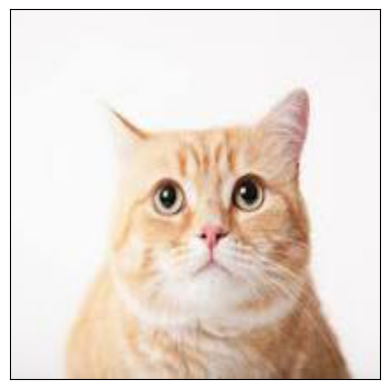

In [109]:
# (1) 이미지 텐서에 담기
transform = transforms.Compose(
    [
        transforms.Resize(size = (512, 512)),
        # 이미지 크기를 512X512로 변환하고 
        transforms.ToTensor()
        # 파이토치용 텐서로 바꿈
    ]
)

image = Image.open('./cat.jpg')
transform_image = transform(image)
print(transform_image.shape)
# pytorch는 (C,W,H)로 인식을 함.
print(np.transpose(transform_image, axes = (1,2,0)).shape)
# matplotlib은 (W,H,C)로 인식을 함.
plt.imshow(np.transpose(transform_image, axes = (1,2,0)))
plt.xticks([])
plt.yticks([])

([], [])

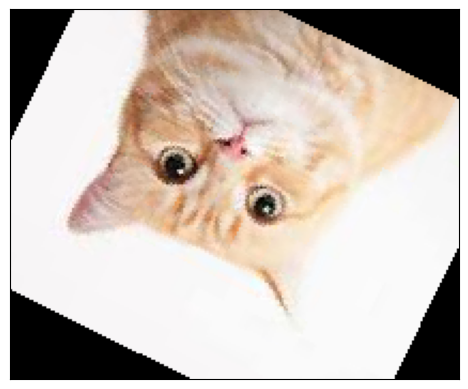

In [119]:
# (2) 이미지 증강 <회전 및 대칭>
# 데이터 수집시 모든 방향의 이미지를 구하기는 어려움 -> 증강으로 해결
# 비현실적인 데이터가 생성될 수 있으므로, 주의하여 사용 -> 거꾸로된 바다 사진 등
transform = transforms.Compose(
    [
        transforms.RandomRotation(degrees = 30, expand = False, center = None),
        # -30~30 사이에 랜덤하게 이미지를 회전
        transforms.RandomHorizontalFlip(p = 0.5),
        # 50%의 확률로 수평대칭 수행
        transforms.RandomVerticalFlip(p = 0.5)
        # 50%의 확률로 수직대칭 수행
    ]
)

image = Image.open("./cat.jpg")
transformed_image = transform(image)
plt.imshow(transformed_image)
plt.xticks([])
plt.yticks([])

([], [])

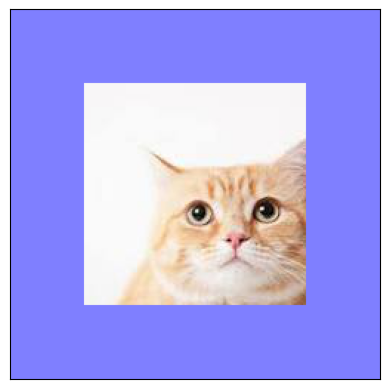

In [124]:
# (3) 자르기 및 패딩
# 주요한 객체가 일부 영역에만 작게 존재하는 경우
# 객체가 존재하는 위치로 이미지를 잘라 불필요한 특징을 감소시키거나
# 패딩을 주어 이미지 크기를 동일한 크기로 맞춤

transform = transforms.Compose(
    [
        transforms.RandomCrop(size = (150,150)),
        # 이미지의 특정 부분을 잘라냄 (원 이미지보다작은 사이즈로 )
        transforms.Pad(padding = 50, fill = (127, 127, 255), padding_mode = "constant")
        # W와 H에 50씩 패딩을 줌(color = (127,127,255)색)
    ]
)

image = Image.open("./cat.jpg")
transform_image = transform(image)
plt.imshow(transform_image)
plt.xticks([])
plt.yticks([])

([], [])

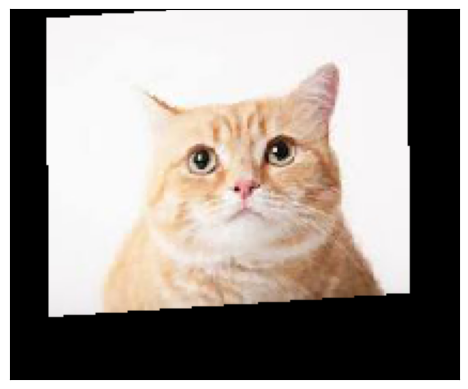

In [132]:
# (4) affine변환
# 기하학적 변환 -> 인위적으로 이미지를 확대, 축소, 위치 변경, 회전, 왜곡 ...(affine, perspective transformation)
# 아핀 변환은 각도(degrees), 이동(translate), 척도(scale), 전단(shear)을 입력해 이미지를 변형하는 방식
transform = transforms.Compose(
    [
        transforms.RandomAffine(
            degrees = 15, translate = (0.2, 0.2),
            scale = (0.8, 1.2), shear = 15
        )
    ]
)

image = Image.open('./cat.jpg')
transform_image = transform(image)
plt.imshow(transform_image)
plt.xticks([])
plt.yticks([])

([], [])

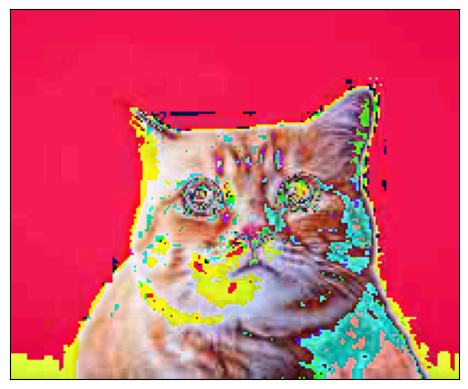

In [135]:
# (5) 색상변환
transform  = transforms.Compose(
    [
        transforms.ColorJitter(
            brightness = 0.3, # 명도
            contrast = 0.3,   # 대비
            saturation = 0.3, # 채도
            hue = 0.3         # 색상
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        ),
        transforms.ToPILImage()
    ]
)

image = Image.open("./cat.jpg")
transform_image = transform(image)
plt.imshow(transform_image)
plt.xticks([])
plt.yticks([])

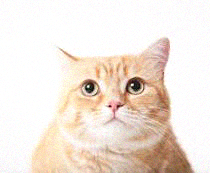

In [153]:
# (6) 노이즈
# 책코드에 오류있음
# https://anushsom.medium.com/image-augmentation-for-creating-datasets-using-pytorch-for-dummies-by-a-dummy-a7c2b08c5bcb
# 를 참조하여 다른 코드 사용
def add_noise(input_image, noise_factor = 0.3):
    inputs = transforms.ToTensor()(input_image)
    noise = inputs + torch.rand_like(inputs) * noise_factor
    noise = torch.clip(noise, 0, 1.)
    output_image = transforms.ToPILImage()
    image = output_image(noise)
    return image
image = Image.open("./cat.jpg")
add_noise(image,0.1)

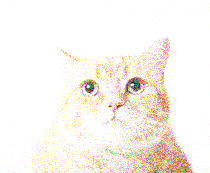

In [154]:
add_noise(image, 0.5)

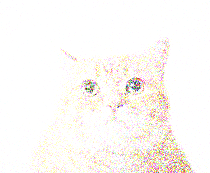

In [155]:
add_noise(image, 1.)

([], [])

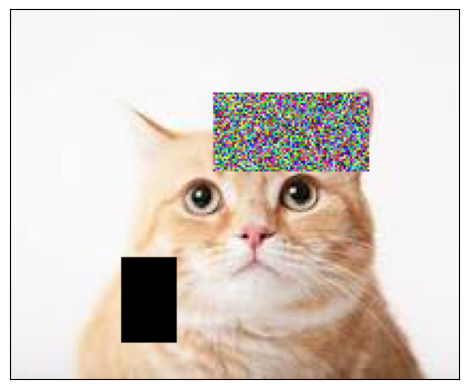

In [164]:
# (7) Cutout & Random Erasing
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomErasing(p = 1., value = 0.),       # Cutout
        transforms.RandomErasing(p = 1., value = "random"), # Random Erasing
        transforms.ToPILImage()
    ]
)

image = Image.open("./cat.jpg")
transform_image = transform(image)
plt.imshow(transform_image)
plt.xticks([])
plt.yticks([])

([], [])

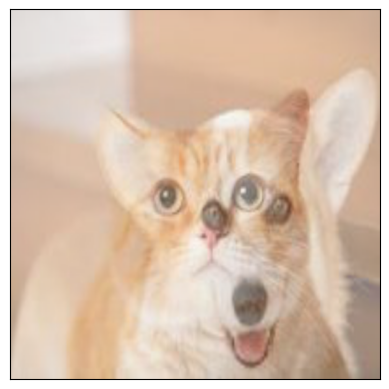

In [167]:
# (8) Mixup and Cutmix
# 두 개 이상의 이미지를 혼합해 새로운 이미지를 생성
# 다중 레이블에 더 견고한 모델을 구성할 수 있음

class Mixup:
    def __init__(self, target, scale, alpha = 0.5, beta = 0.5):
        self.target = target
        self.scale = scale
        self.alpha = alpha
        self.beta = beta
    
    def __call__(self, image):
        image = np.array(image)
        target = self.target.resize(self.scale)
        target = np.array(target)
        mix_image = image * self.alpha + target * self.beta
        return Image.fromarray(mix_image.astype(np.uint8))


transform = transforms.Compose(
    [
        transforms.Resize((512,512)),
        Mixup(
            target = Image.open("./dog.jpg"),
            scale = (512, 512),
            alpha = 0.5,
            beta = 0.5
        )
    ]
)

image = Image.open("./cat.jpg")
transformed_image = transform(image)
plt.imshow(transformed_image)
plt.xticks([])
plt.yticks([])

# END(2023-12-28)